# Optimize

run and compare optimization frameworks

- hyperopt
- optuna
- nevergrad
- platypus
- scipy (Powell)
- ax


In [1]:
from datetime import datetime
from functools import partial

import pytest
import numpy as np
import pandas as pd
import scipy
# import pandas_datareader as pdr

from SWRsimulation import SWRsimulation

# TODO:
# simulates take override simulation args
# redo history several times without reinitializing with different parameters
# init creates a list of samples, n_trials by n_ret_years
# for history , simulate creates a generator from samples and returns them
# chart - show strategy, fixed, var, stock, add optimizer to title
# chart of all optimizers, do with plotly, hover shows gamma, value, optimizer, elapsed time
# do with deathrate
# multithreading, optimize for speed

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))

numpy 1.19.5
pandas 1.2.1
scipy 1.6.0


In [2]:
N_TRIALS = 1000

In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


In [4]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

,stocks,bonds,cpi
Year,,,
1928,0.438112,0.032196,-0.011522
1929,-0.082979,0.030179,0.000000
1930,-0.251236,0.005398,-0.026712
1931,-0.438375,-0.156808,-0.089321
1932,-0.086424,0.235896,-0.103014
...,...,...,...
2016,0.117731,0.103651,0.012616
2017,0.216055,0.097239,0.021301
2018,-0.042269,-0.027626,0.024426


In [5]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

,stocks,bonds
Year,,
1928,0.454874,0.044227
1929,-0.082979,0.030179
1930,-0.230686,0.032991
1931,-0.383290,-0.074106
1932,0.018495,0.377832
...,...,...
2016,0.103805,0.089901
2017,0.190692,0.074354
2018,-0.065104,-0.050811


In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30
from functools import partial

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulation({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend},
        'evaluation': {},
        'analysis': {}    
    })
    s.simulate()
    return -SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9519.256017841699
-9519.256017841699
-9519.256017841699
-9519.256017841699


In [7]:
from scipy import optimize
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method
# initial guess
x0 = np.array([0.5, 5.0, 1.0])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = 100

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time 
    
    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))



2021-02-08 11:56:57 Starting scipy.optimize (L-BFGS-B), gamma 0, 100 iterations
2021-02-08 11:57:00 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 5 iterations in 0:00:03.332998
2021-02-08 11:57:00 best value -15532.416056, best params [0.         6.20410436 1.        ]
2021-02-08 11:57:00 Starting scipy.optimize (L-BFGS-B), gamma 1, 100 iterations
2021-02-08 11:57:04 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 5 iterations in 0:00:03.357051
2021-02-08 11:57:04 best value -14329.303955, best params [0.         6.33137422 1.        ]
2021-02-08 11:57:04 Starting scipy.optimize (L-BFGS-B), gamma 2, 100 iterations
2021-02-08 11:57:10 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 10 iterations in 0:00:06.717615
2021-02-08 11:57:10 best value -13132.511625, best params [0.         6.49626204 1.        ]
2021-02-08 11:57:10 Starting scipy.optimize (L-BFGS-B), gamma 4, 100 iterations
2021-02-08 11:57:17 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 4, 11 

In [8]:
results_dict = {}

In [9]:
results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value']]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,0.000000,0.000000,6.204104,-15532.416056
1,1,1.000000,0.000000,0.000000,6.331374,-14329.303955
2,2,1.000000,0.000000,0.000000,6.496262,-13132.511625
3,4,1.000000,0.000000,0.000000,6.790925,-11206.793432
4,6,0.775916,0.224084,1.678529,5.958820,-10113.824493
5,8,0.761725,0.238275,2.741288,3.155909,-9755.148796
6,10,0.729424,0.270576,2.726143,3.018257,-9408.861510
7,12,0.716221,0.283779,3.026949,2.447771,-9174.762741
8,14,0.665883,0.334117,1.630291,6.101387,-8698.980749
9,16,0.700356,0.299644,2.974660,2.322801,-8855.534067


In [10]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14329.303955197636

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f87fc6e2430>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 2.9746595934338638, 'variable_pct': 2.3228010851549543}
mean annual spending over all cohorts 5.62
0.00% of portfolios exhausted by final year


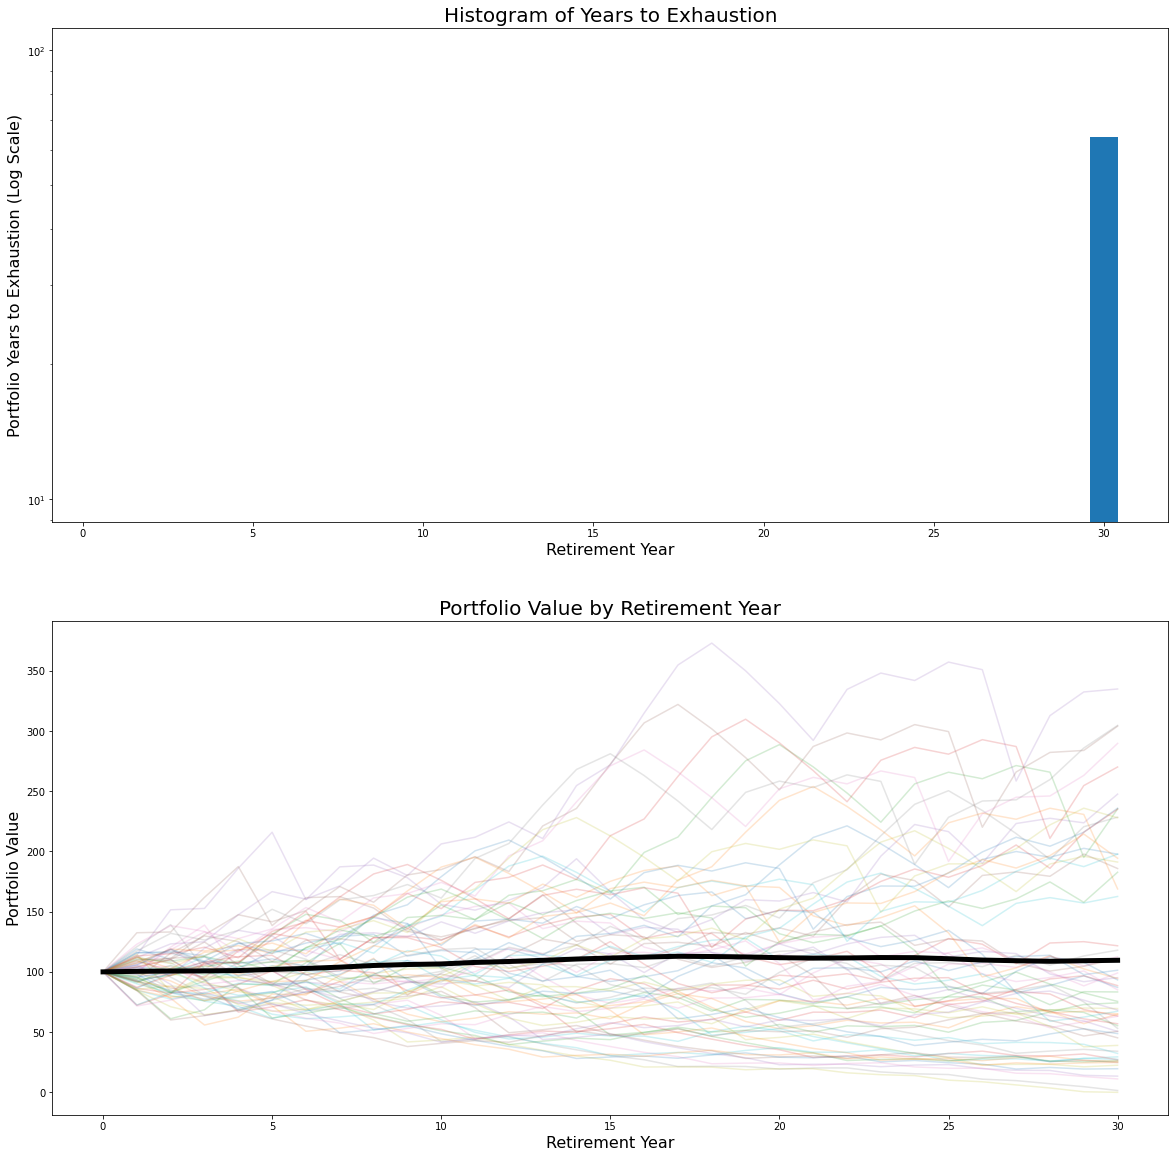

In [11]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()

s.analyze()


In [12]:
import optuna   # https://optuna.org/
print("%s %s" % ('optuna', optuna.__version__))
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(gamma, trial):
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    oobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    return oobjective([fixed_spend, variable_spend, alloc_stocks])

study_params = []
study_values = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

n_trials = N_TRIALS
optimizer = "optuna"

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=n_trials)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    time_elapsed = datetime.now() - start_time 
    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), study.best_value, study.best_params))
    

optuna 2.5.0
2021-02-08 12:00:44 Starting optuna, gamma 0, 1000 trials
2021-02-08 12:02:51 Finishing optimizer optuna, gamma 0, 1000 trials in 0:02:06.835861
2021-02-08 12:02:51 best value -15531.189133, best params {'fixed_spend': 0.0028485247410660964, 'variable_spend': 6.22752318752343, 'alloc_stocks': 0.9999630631471937}
2021-02-08 12:02:51 Starting optuna, gamma 1, 1000 trials
2021-02-08 12:04:58 Finishing optimizer optuna, gamma 1, 1000 trials in 0:02:06.971401
2021-02-08 12:04:58 best value -14328.640189, best params {'fixed_spend': 0.0001116247769738577, 'variable_spend': 6.27956583641445, 'alloc_stocks': 0.9999599925066524}
2021-02-08 12:04:58 Starting optuna, gamma 2, 1000 trials
2021-02-08 12:07:04 Finishing optimizer optuna, gamma 2, 1000 trials in 0:02:06.719521
2021-02-08 12:07:04 best value -13131.744747, best params {'fixed_spend': 0.0025813068281473205, 'variable_spend': 6.457092971918273, 'alloc_stocks': 0.9999693100511878}
2021-02-08 12:07:04 Starting optuna, gamma 4

In [13]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value']]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,0.999963,0.000037,0.002849,6.227523,-15531.189133
1,1,0.999960,0.000040,0.000112,6.279566,-14328.640189
2,2,0.999969,0.000031,0.002581,6.457093,-13131.744747
3,4,0.999964,0.000036,0.000114,6.791180,-11206.755378
4,6,0.820863,0.179137,2.539029,3.688851,-10265.153436
5,8,0.766296,0.233704,2.757056,3.133132,-9754.362565
6,10,0.737915,0.262085,2.910621,2.732028,-9416.852751
7,12,0.718082,0.281918,3.059833,2.395182,-9174.601826
8,14,0.713432,0.286568,2.927723,2.458509,-8992.638989
9,16,0.694185,0.305815,3.017520,2.230186,-8855.034859


In [14]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14328.64018914833

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f87e8144c80>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 3.0175199447268324, 'variable_pct': 2.2301864549879755}
mean annual spending over all cohorts 5.58
0.00% of portfolios exhausted by final year


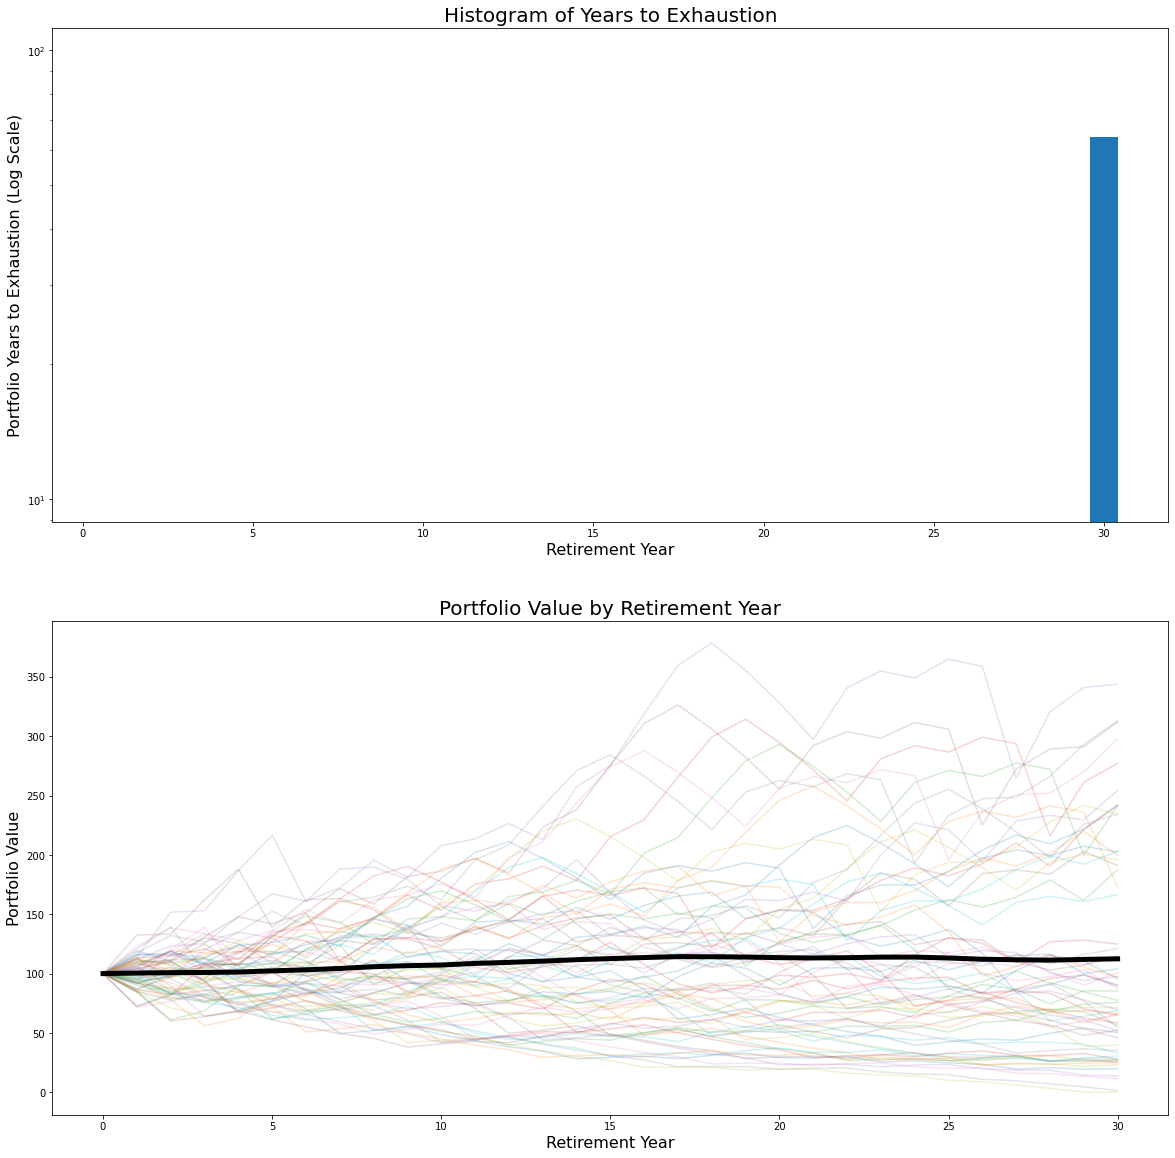

In [15]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()

s.analyze()

In [16]:
import hyperopt  # http://hyperopt.github.io/hyperopt/
from hyperopt import fmin, tpe, hp
print("%s %s" % ('hyperopt', hyperopt.__version__))

n_trials = N_TRIALS
optimizer = "hyperopt"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]
for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    hobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    best = fmin(fn=hobjective,
                space={'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10),
                       'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                      },
                algo=tpe.suggest,
                max_evals=n_trials)
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), study.best_params))
        

hyperopt 0.2.5
2021-02-08 12:21:48 Starting hyperopt, gamma 0, 1000 trials
100%|██████████| 1000/1000 [02:11<00:00,  7.61trial/s, best loss: -15531.675810191036]
2021-02-08 12:24:00 Finishing optimizer hyperopt, gamma 0, 1000 trials in 0:02:11.443181
2021-02-08 12:24:00 best params {'fixed_spend': 3.0175199447268324, 'variable_spend': 2.2301864549879755, 'alloc_stocks': 0.6941846310397924}
2021-02-08 12:24:00 Starting hyperopt, gamma 1, 1000 trials
100%|██████████| 1000/1000 [02:11<00:00,  7.63trial/s, best loss: -14327.12450534946]
2021-02-08 12:26:11 Finishing optimizer hyperopt, gamma 1, 1000 trials in 0:02:11.044075
2021-02-08 12:26:11 best params {'fixed_spend': 3.0175199447268324, 'variable_spend': 2.2301864549879755, 'alloc_stocks': 0.6941846310397924}
2021-02-08 12:26:11 Starting hyperopt, gamma 2, 1000 trials
100%|██████████| 1000/1000 [02:11<00:00,  7.59trial/s, best loss: -13129.194738413176]
2021-02-08 12:28:23 Finishing optimizer hyperopt, gamma 2, 1000 trials in 0:02:11.7

In [17]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
study_values = []
for t in results.itertuples():
    hobjective = partial(ce_experiment, N_RET_YEARS, t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,0.999991,0.000009,0.001971,6.231244,-15531.675810
1,1,0.999719,0.000281,0.000889,6.337738,-14327.124505
2,2,0.999236,0.000764,0.000063,6.526500,-13129.194738
3,4,0.999513,0.000487,0.001101,6.893285,-11205.474039
4,6,0.821287,0.178713,2.555140,3.627893,-10264.789492
5,8,0.763705,0.236295,2.831033,2.950514,-9753.206765
6,10,0.736937,0.263063,2.869497,2.810790,-9416.151229
7,12,0.695730,0.304270,3.050484,2.366908,-9172.247580
8,14,0.698127,0.301873,2.979996,2.383382,-8991.378668
9,16,0.720542,0.279458,2.874679,2.557588,-8851.446103


In [18]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14327.12450534946

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f87e7fe03c0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 2.8746787203646678, 'variable_pct': 2.557588131708421}
mean annual spending over all cohorts 5.70
0.00% of portfolios exhausted by final year


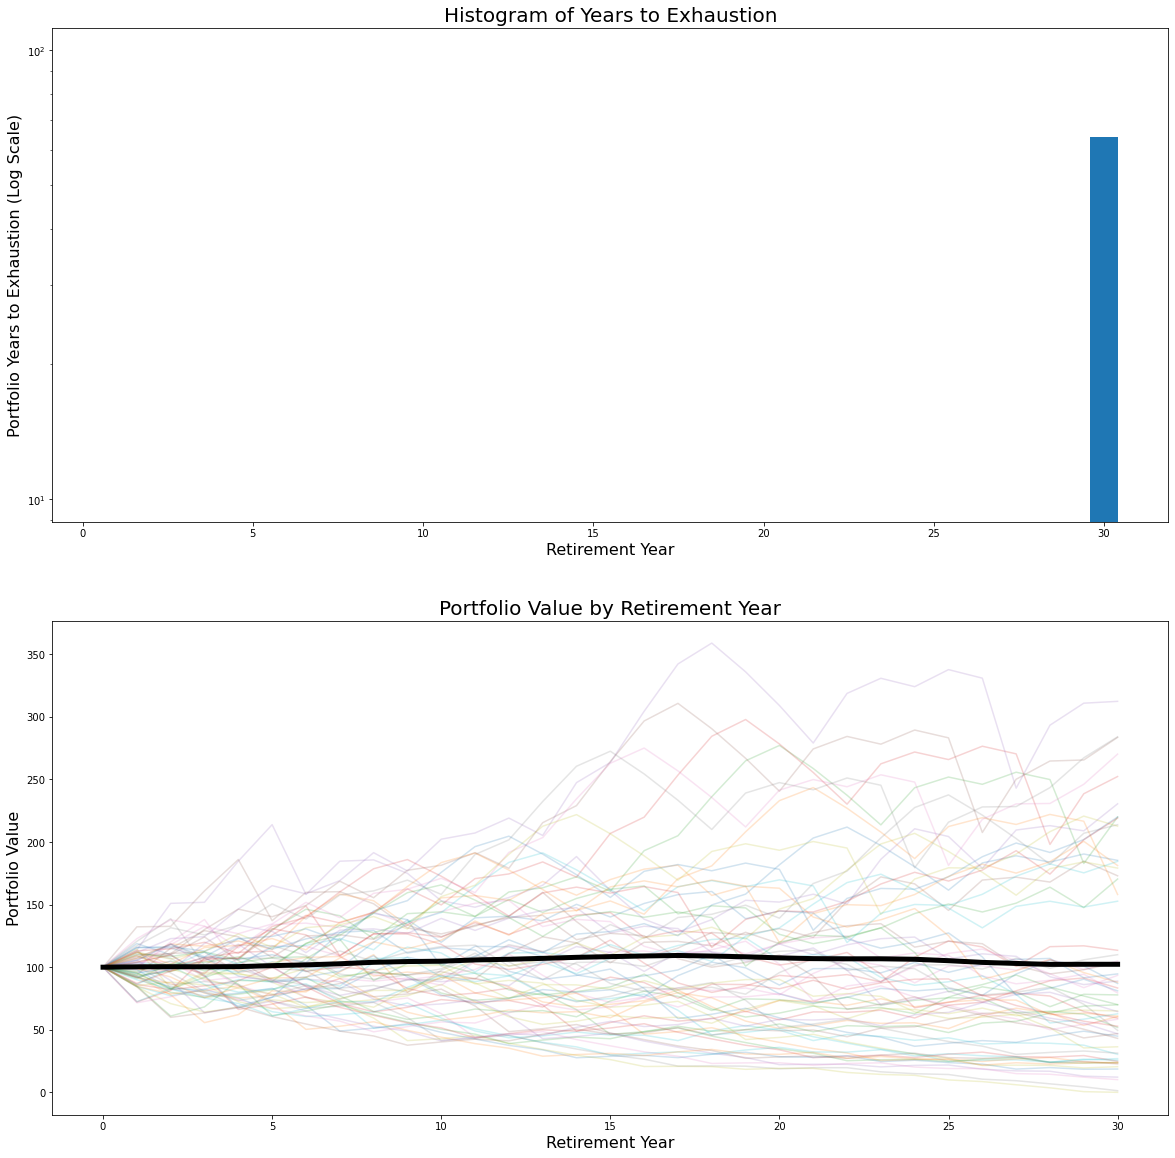

In [19]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()

In [20]:
# https://github.com/Project-Platypus/Platypus
import platypus
from platypus import MOEAD, Problem, Real
print("%s %s" % ("platypus", platypus.__version__))
n_trials = N_TRIALS
optimizer = "platypus (MOEAD)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    # number inputs, outputs
    problem = Problem(3, 1)
    # ranges
    problem.types[0] = Real(0, 5)   # fixed_spend
    problem.types[1] = Real(0, 10)  # variable_spend
    problem.types[2] = Real(0, 1)   # alloc_stocks

    # platypus wants a numpy array return because it's a multi-objective algo
    f = partial(ce_experiment, N_RET_YEARS, gamma)
    def pobjective(params):
        return np.array([f(params)])

    problem.function = pobjective
    algorithm = MOEAD(problem)
    algorithm.run(n_trials)
    best = sorted([(s.objectives[0], s.variables) for s in algorithm.result if s.feasible])[0]
    # tuple of best objective value, best params
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), best))


platypus 1.0.4
2021-02-08 12:43:39 Starting platypus (MOEAD), gamma 0, 1000 trials
2021-02-08 12:45:56 Finishing optimizer platypus (MOEAD), gamma 0, 1000 trials in 0:02:17.440276
2021-02-08 12:45:56 best params (-15532.3015569528, [0.00041405536225614, 6.208813799017272, 0.9999999943064593])
2021-02-08 12:45:56 Starting platypus (MOEAD), gamma 1, 1000 trials
2021-02-08 12:48:13 Finishing optimizer platypus (MOEAD), gamma 1, 1000 trials in 0:02:16.497008
2021-02-08 12:48:13 best params (-14329.178479508873, [0.00018410170066124332, 6.340725417018154, 0.9999896961197554])
2021-02-08 12:48:13 Starting platypus (MOEAD), gamma 2, 1000 trials
2021-02-08 12:50:31 Finishing optimizer platypus (MOEAD), gamma 2, 1000 trials in 0:02:18.106309
2021-02-08 12:50:31 best params (-13123.100107726248, [0.007101208554724792, 6.248091446805451, 0.9997182320759161])
2021-02-08 12:50:31 Starting platypus (MOEAD), gamma 4, 1000 trials
2021-02-08 12:52:48 Finishing optimizer platypus (MOEAD), gamma 4, 1000 

In [21]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,5.693541e-09,0.000414,6.208814,-15532.301557
1,1,0.999990,1.030388e-05,0.000184,6.340725,-14329.178480
2,2,0.999718,2.817679e-04,0.007101,6.248091,-13123.100108
3,4,0.925553,7.444742e-02,2.209344,4.300881,-11148.876853
4,6,0.819333,1.806668e-01,2.595531,3.542148,-10265.452180
5,8,0.755868,2.441316e-01,2.807042,3.006881,-9753.383640
6,10,0.757678,2.423222e-01,2.964850,2.634822,-9415.293849
7,12,0.715992,2.840077e-01,3.065034,2.377309,-9174.578294
8,14,0.708006,2.919939e-01,3.050856,2.302370,-8992.114633
9,16,0.704872,2.951284e-01,2.948093,2.379688,-8855.332339


In [22]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14329.178479508873

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f87e7f0e890>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 2.948093020393952, 'variable_pct': 2.3796879116206497}
mean annual spending over all cohorts 5.64
0.00% of portfolios exhausted by final year


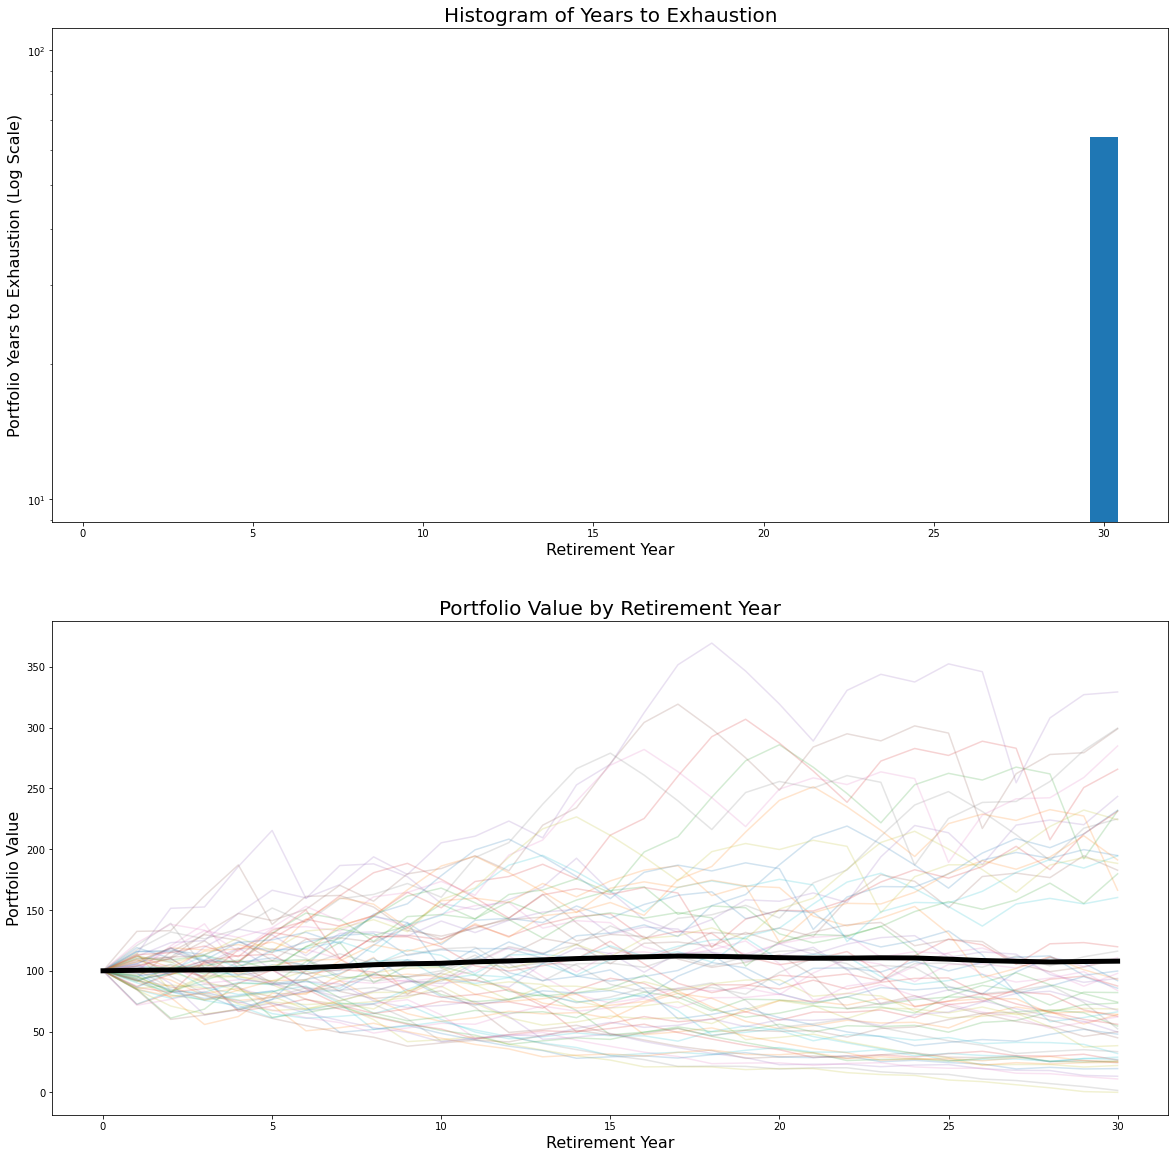

In [23]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()

In [24]:
import nevergrad as ng  # https://facebookresearch.github.io/nevergrad/optimization.html
print("%s %s" % ("nevergrad", ng.__version__))

from concurrent import futures

n_trials = N_TRIALS
optimizer = "nevergrad (OnePlusOne)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    nobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    opt = ng.optimizers.OnePlusOne(parametrization=3, budget=n_trials, num_workers=10)

    opt.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[0] <= 5)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] <= 10)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] <= 1)
    with futures.ThreadPoolExecutor(max_workers=opt.num_workers) as executor:
        recommendation = opt.minimize(nobjective, executor=executor, batch_mode=False)
    
    time_elapsed = datetime.now() - start_time 
    study_params.append((recommendation.loss, recommendation.value.tolist()))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %f" % (datestr(), recommendation.value, recommendation.loss))
        


nevergrad 0.4.3
2021-02-08 13:06:36 Starting nevergrad (OnePlusOne), gamma 0, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")


2021-02-08 13:09:58 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 0, 1000 trials in 0:03:21.406771
2021-02-08 13:09:58 best params [4.68467893 2.18604681 1.        ] value -13432.514577
2021-02-08 13:09:58 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 1, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")


2021-02-08 13:13:12 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 1, 1000 trials in 0:03:14.423421
2021-02-08 13:13:12 best params [2.83128257 3.97304331 1.        ] value -13617.118396
2021-02-08 13:13:12 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 2, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-08 13:16:32 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 2, 1000 trials in 0:03:19.938302
2021-02-08 13:16:32 best params [2.58093586 3.17728357 1.        ] value -12435.010087
2021-02-08 13:16:32 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 4, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-08 13:20:03 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 4, 1000 trials in 0:03:30.604212
2021-02-08 13:20:03 best params [2.30706676 4.19836118 0.91922828] value -11146.667981
2021-02-08 13:20:03 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 6, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-08 13:23:30 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 6, 1000 trials in 0:03:27.007413
2021-02-08 13:23:30 best params [1.69141696 5.6447     0.79493923] value -10141.877453
2021-02-08 13:23:30 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 8, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-08 13:26:56 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 8, 1000 trials in 0:03:26.580093
2021-02-08 13:26:56 best params [3.08405569 2.48275215 0.78388834] value -9734.948778
2021-02-08 13:26:56 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 10, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")


2021-02-08 13:30:29 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 10, 1000 trials in 0:03:32.150651
2021-02-08 13:30:29 best params [2.78750674 3.02617319 0.73037488] value -9414.745204
2021-02-08 13:30:29 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 12, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")


2021-02-08 13:33:56 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 12, 1000 trials in 0:03:27.818131
2021-02-08 13:33:56 best params [3.2824981  1.92552201 0.73628121] value -9163.693912
2021-02-08 13:33:56 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 14, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning: Could not bypass the constraint after 1000 tentatives, sending candidate anyway.
  warnings.warn(
/home/ubuntu/anaconda3/

2021-02-08 13:37:28 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 14, 1000 trials in 0:03:31.755703
2021-02-08 13:37:28 best params [2.93133168 2.45546159 0.70736774] value -8992.772352
2021-02-08 13:37:28 Starting Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 16, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:320: UserWarning: Clipping very high value nan in tell (rescale the cost function?).
  warnings.warn(f"Clipping very high value {loss} in tell (rescale the cost function?).")


2021-02-08 13:40:57 Finishing optimizer Instance of OnePlusOne(parametrization=Array{(3,),constr}, budget=1000, num_workers=10), gamma 16, 1000 trials in 0:03:29.188964
2021-02-08 13:40:57 best params [2.04499288 4.75953806 0.67432393] value -8689.602117


In [25]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results


,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,1.332268e-15,4.684679,2.186047,-13432.514577
1,1,1.000000,1.110223e-15,2.831283,3.973043,-13617.118396
2,2,1.000000,2.331468e-15,2.580936,3.177284,-12435.010087
3,4,0.919228,8.077172e-02,2.307067,4.198361,-11146.667981
4,6,0.794939,2.050608e-01,1.691417,5.644700,-10141.877453
5,8,0.783888,2.161117e-01,3.084056,2.482752,-9734.948778
6,10,0.730375,2.696251e-01,2.787507,3.026173,-9414.745204
7,12,0.736281,2.637188e-01,3.282498,1.925522,-9163.693912
8,14,0.707368,2.926323e-01,2.931332,2.455462,-8992.772352
9,16,0.674324,3.256761e-01,2.044993,4.759538,-8689.602117


In [26]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-13617.118396226944

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f87e821eeb0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 2.044992880285092, 'variable_pct': 4.759538060366071}
mean annual spending over all cohorts 6.10
0.00% of portfolios exhausted by final year


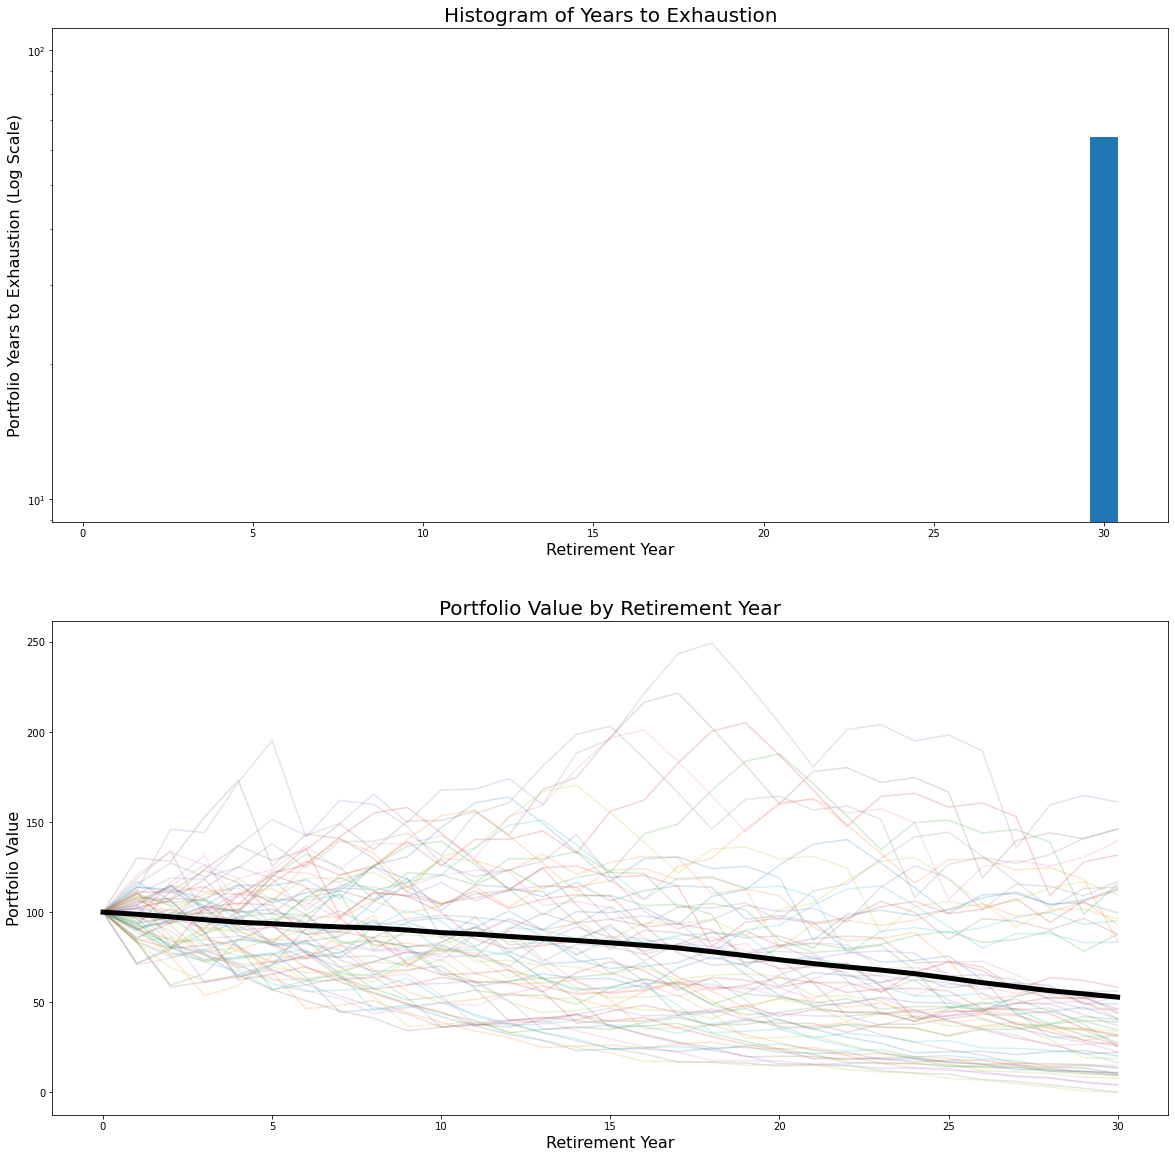

In [27]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()

In [29]:
import ax  # https://ax.dev/
print("%s %s" % ("ax", ax.__version__))

n_trials = N_TRIALS // 10
optimizer = "ax (defaults)"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    aobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    
    best_parameters, best_values, experiment, model = ax.optimize(
        parameters=[
            {
                "name": "fixed_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 5.0],
            },
            {
                "name": "variable_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 10.0],
            },
            {
                "name": "alloc_stocks",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 1.0],
            },
        ],
        evaluation_function=aobjective,
        minimize=True,
        total_trials=n_trials,
        #verbose_logging=False
    )
    
    time_elapsed = datetime.now() - start_time 
    
    study_params.append((best_values[0]['objective'], 
                         [best_parameters['fixed_spend'], 
                          best_parameters['variable_spend'], 
                          best_parameters['alloc_stocks']]
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))


[INFO 02-08 14:18:12] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-08 14:18:12] ax.service.managed_loop: Started full optimization with 100 steps.
[INFO 02-08 14:18:12] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-08 14:18:12] ax.service.managed_loop: Running optimization trial 2...


ax 0.1.19
2021-02-08 14:18:12 Starting ax (defaults), gamma 0, 100 trials


[INFO 02-08 14:18:12] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:18:12] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:18:12] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:18:12] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:18:13] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:18:13] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:18:14] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:18:14] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:18:15] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:18:15] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:18:16] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:18:16] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:18:17] ax.service.managed_loop: 

[INFO 02-08 14:18:46] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:18:46 Finishing optimizer ax (defaults), gamma 0, 100 trials in 0:00:34.350495
2021-02-08 14:18:46 best params -15530.42049968983 value {'fixed_spend': 1.2523597557362863e-12, 'variable_spend': 6.090443589331478, 'alloc_stocks': 0.9999999999999653}
2021-02-08 14:18:46 Starting ax (defaults), gamma 1, 100 trials


[INFO 02-08 14:18:46] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:18:46] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:18:47] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:18:47] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:18:47] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:18:48] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:18:49] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:18:50] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:18:50] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:18:50] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:18:51] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:18:51] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:18:52] ax.service.managed_loop: 

[INFO 02-08 14:19:23] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:19:23 Finishing optimizer ax (defaults), gamma 1, 100 trials in 0:00:36.950522
2021-02-08 14:19:23 best params -14328.395155858801 value {'fixed_spend': 1.6523246810587368e-07, 'variable_spend': 6.248927448731624, 'alloc_stocks': 0.9999993136226659}
2021-02-08 14:19:23 Starting ax (defaults), gamma 2, 100 trials


[INFO 02-08 14:19:23] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:19:23] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:19:23] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:19:24] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:19:24] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:19:24] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:19:25] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:19:25] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:19:26] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:19:27] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:19:27] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:19:27] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:19:28] ax.service.managed_loop: 

[INFO 02-08 14:19:59] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:19:59 Finishing optimizer ax (defaults), gamma 2, 100 trials in 0:00:36.420384
2021-02-08 14:19:59 best params -13132.007050537963 value {'fixed_spend': 1.4687026811109645e-07, 'variable_spend': 6.429429106848885, 'alloc_stocks': 0.9999999996250142}
2021-02-08 14:19:59 Starting ax (defaults), gamma 4, 100 trials


[INFO 02-08 14:20:00] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:20:00] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:20:00] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:20:00] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:20:00] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:20:01] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:20:01] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:20:02] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:20:02] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:20:03] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:20:03] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:20:03] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:20:04] ax.service.managed_loop: 

[INFO 02-08 14:20:36] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:20:35 Finishing optimizer ax (defaults), gamma 4, 100 trials in 0:00:36.028167
2021-02-08 14:20:35 best params -11205.813930725864 value {'fixed_spend': 7.32264067045747e-16, 'variable_spend': 6.899813063389688, 'alloc_stocks': 0.9999999999999999}
2021-02-08 14:20:35 Starting ax (defaults), gamma 6, 100 trials


[INFO 02-08 14:20:36] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:20:36] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:20:36] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:20:36] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:20:36] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:20:37] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:20:37] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:20:38] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:20:38] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:20:39] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:20:39] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:20:40] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:20:40] ax.service.managed_loop: 

[INFO 02-08 14:21:17] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:21:17 Finishing optimizer ax (defaults), gamma 6, 100 trials in 0:00:41.710064
2021-02-08 14:21:17 best params -10264.980653449682 value {'fixed_spend': 2.548260027075055, 'variable_spend': 3.647336444621416, 'alloc_stocks': 0.8012072089163409}
2021-02-08 14:21:17 Starting ax (defaults), gamma 8, 100 trials


[INFO 02-08 14:21:17] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:21:18] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:21:18] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:21:18] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:21:18] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:21:19] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:21:19] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:21:19] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:21:20] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:21:20] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:21:21] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:21:21] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:21:21] ax.service.managed_loop: 

[INFO 02-08 14:22:03] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:22:02 Finishing optimizer ax (defaults), gamma 8, 100 trials in 0:00:45.291236
2021-02-08 14:22:02 best params -9753.393842229563 value {'fixed_spend': 2.7817979830847337, 'variable_spend': 3.0782167431792495, 'alloc_stocks': 0.7559728765739143}
2021-02-08 14:22:02 Starting ax (defaults), gamma 10, 100 trials


[INFO 02-08 14:22:03] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:22:03] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:22:03] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:22:03] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:22:03] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:22:04] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:22:05] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:22:06] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:22:06] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:22:07] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:22:08] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:22:09] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:22:10] ax.service.managed_loop: 

[INFO 02-08 14:22:55] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:22:55 Finishing optimizer ax (defaults), gamma 10, 100 trials in 0:00:52.383855
2021-02-08 14:22:55 best params -9415.544432167455 value {'fixed_spend': 2.835960794750001, 'variable_spend': 2.9117263161563267, 'alloc_stocks': 0.7197147042287677}
2021-02-08 14:22:55 Starting ax (defaults), gamma 12, 100 trials


[INFO 02-08 14:22:55] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:22:55] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:22:55] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:22:55] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:22:56] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:22:57] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:22:57] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:22:58] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:22:58] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:22:59] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:22:59] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:23:00] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:23:01] ax.service.managed_loop: 

[INFO 02-08 14:23:49] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:23:49 Finishing optimizer ax (defaults), gamma 12, 100 trials in 0:00:53.850783
2021-02-08 14:23:49 best params -9174.405285251032 value {'fixed_spend': 3.009828356533528, 'variable_spend': 2.486983205449945, 'alloc_stocks': 0.7247184896447274}
2021-02-08 14:23:49 Starting ax (defaults), gamma 14, 100 trials


[INFO 02-08 14:23:49] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:23:49] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:23:49] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:23:49] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:23:50] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:23:50] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:23:51] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:23:52] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:23:53] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:23:54] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:23:55] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:23:55] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:23:56] ax.service.managed_loop: 

[INFO 02-08 14:24:57] ax.service.managed_loop: Running optimization trial 2...


2021-02-08 14:24:56 Finishing optimizer ax (defaults), gamma 14, 100 trials in 0:01:07.787184
2021-02-08 14:24:56 best params -8986.134545088025 value {'fixed_spend': 3.025678151858316, 'variable_spend': 2.297320248010399, 'alloc_stocks': 0.6716430773851239}
2021-02-08 14:24:56 Starting ax (defaults), gamma 16, 100 trials


[INFO 02-08 14:24:57] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-08 14:24:57] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-08 14:24:57] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-08 14:24:57] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-08 14:24:57] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-08 14:24:58] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-08 14:24:58] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-08 14:24:59] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-08 14:24:59] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-08 14:25:00] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-08 14:25:00] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-08 14:25:01] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-08 14:25:01] ax.service.managed_loop: 

2021-02-08 14:25:53 Finishing optimizer ax (defaults), gamma 16, 100 trials in 0:00:57.073442
2021-02-08 14:25:53 best params -8855.48933487514 value {'fixed_spend': 3.0026886926407075, 'variable_spend': 2.2703073078337863, 'alloc_stocks': 0.7021411294694067}


In [30]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results=results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend']]
results['value'] = [s[0] for s in study_params]
results_dict[optimizer] = results.copy()
results

,gamma,alloc_stocks,alloc_bonds,fixed_spend,variable_spend,value
0,0,1.000000,3.474998e-14,1.252360e-12,6.090444,-15530.420500
1,1,0.999999,6.863773e-07,1.652325e-07,6.248927,-14328.395156
2,2,1.000000,3.749858e-10,1.468703e-07,6.429429,-13132.007051
3,4,1.000000,1.110223e-16,7.322641e-16,6.899813,-11205.813931
4,6,0.801207,1.987928e-01,2.548260e+00,3.647336,-10264.980653
5,8,0.755973,2.440271e-01,2.781798e+00,3.078217,-9753.393842
6,10,0.719715,2.802853e-01,2.835961e+00,2.911726,-9415.544432
7,12,0.724718,2.752815e-01,3.009828e+00,2.486983,-9174.405285
8,14,0.671643,3.283569e-01,3.025678e+00,2.297320,-8986.134545
9,16,0.702141,2.978589e-01,3.002689e+00,2.270307,-8855.489335


In [31]:
resultsrow = results.iloc[1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

ce_experiment(N_RET_YEARS,
              GAMMA,
              {'fixed_spend': FIXED_SPEND, 
               'variable_spend': VARIABLE_SPEND, 
               'alloc_stocks': ALLOC_STOCKS})


-14328.388671309127

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulation.historical_trials at 0x7f87cf236120>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed_pct': 3.0026886926407075, 'variable_pct': 2.2703073078337863}
mean annual spending over all cohorts 5.60
0.00% of portfolios exhausted by final year


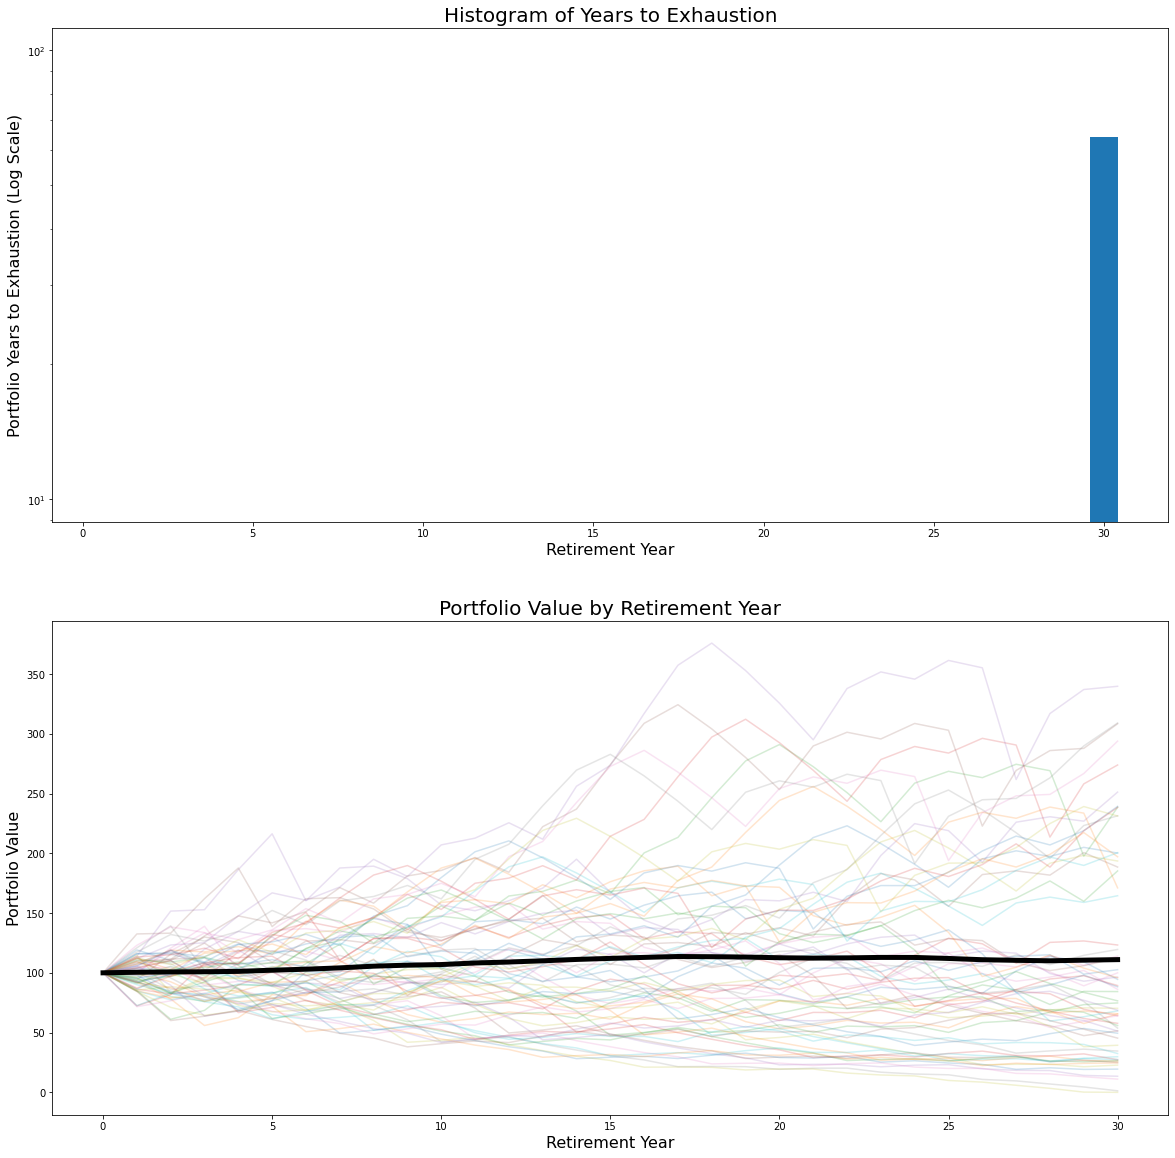

In [32]:
resultsrow = results.iloc[-1]
FIXED_SPEND = resultsrow.fixed_spend
VARIABLE_SPEND = resultsrow.variable_spend
ALLOC_STOCKS = resultsrow.alloc_stocks
ALLOC_BONDS = 1 - ALLOC_STOCKS
GAMMA = resultsrow.gamma
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulation({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
#                    'montecarlo': NTRIALS,
#                    'montecarlo_replacement': True,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()

In [58]:
for z in results_dict.keys():
    if type(z) == str:
        pass
    else:
        results_dict['nevergrad (OnePlusOne)'] = results_dict[z]
        del results_dict[z]

RuntimeError: dictionary changed size during iteration

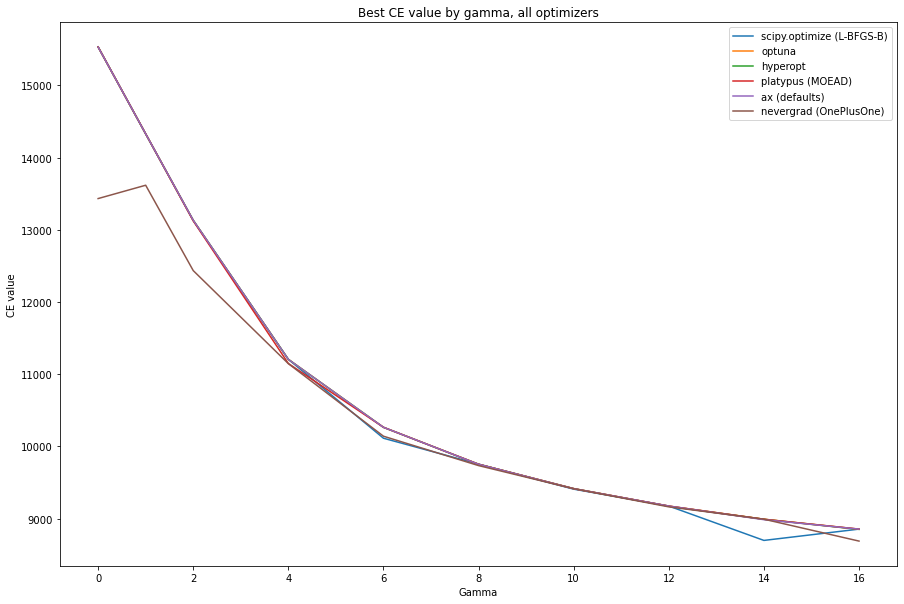

In [65]:
# plot all results
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.title('Best CE value by gamma, all optimizers')
plt.xlabel('Gamma')
plt.ylabel('CE value')
for opt in results_dict.keys():
    plt.plot(results_dict[opt]['gamma'], -results_dict[opt]['value'], label=opt)
    
plt.legend();



In [33]:
z = pd.read_csv('log.csv')

In [34]:
z.columns

Index(['Unnamed: 0', 'start_time', 'end_time', 'time_elapsed', 'objective',
       'optimizer', 'n_dim', 'n_trials', 'reported_trials', 'best_value',
       'best_params'],
      dtype='object')

In [35]:
with pd.option_context('display.max_rows', None):
    display(z.sort_values(['optimizer', 'objective', 'n_dim']))

,Unnamed: 0,start_time,end_time,time_elapsed,objective,optimizer,n_dim,n_trials,reported_trials,best_value,best_params
1113,1113,2021-02-06 16:48:17.950222,2021-02-06 16:48:19.892103,0 days 00:00:01.941887,damavandi_on_cube,ax_default_cube,2,20,20,1.460153e+02,"[1.0, 1.0]"
1151,1151,2021-02-06 16:49:41.243960,2021-02-06 16:50:14.201880,0 days 00:00:32.957925,damavandi_on_cube,ax_default_cube,2,150,150,1.460154e+02,"[0.999999999999834, 0.9999999999992198]"
1189,1189,2021-02-06 16:50:28.253896,2021-02-06 16:50:40.873234,0 days 00:00:12.619344,damavandi_on_cube,ax_default_cube,6,20,20,1.460153e+02,"[1.0, 1.0, 0.5984907783533135, 0.2568462632922..."
1226,1226,2021-02-06 16:53:10.018746,2021-02-06 16:55:03.635415,0 days 00:01:53.616675,damavandi_on_cube,ax_default_cube,6,150,150,1.460153e+02,"[0.999999999727744, 0.9999999989527837, 0.8662..."
1263,1263,2021-02-06 16:55:12.801133,2021-02-06 16:55:13.424007,0 days 00:00:00.622879,damavandi_on_cube,ax_default_cube,20,20,20,1.462767e+02,"[0.7503636926412582, 0.9929247386753559, 0.809..."
1296,1296,2021-02-06 17:16:07.765430,2021-02-06 17:43:29.194201,0 days 00:27:21.428777,damavandi_on_cube,ax_default_cube,20,150,150,1.460153e+02,"[1.0, 1.0, 0.8265373829093305, 0.3380487282901..."
673,673,2021-02-06 15:42:39.725087,2021-02-06 15:42:45.059096,0 days 00:00:05.334014,deap_on_cube,ax_default_cube,2,20,20,2.053950e+00,"[0.5495600446647563, 0.5653392057671646]"
711,711,2021-02-06 15:45:03.141811,2021-02-06 15:46:34.963512,0 days 00:01:31.821707,deap_on_cube,ax_default_cube,2,150,150,1.185640e+00,"[0.5396106507415788, 0.5213589316734443]"
749,749,2021-02-06 15:46:49.965674,2021-02-06 15:47:00.275020,0 days 00:00:10.309352,deap_on_cube,ax_default_cube,6,20,20,4.320311e+00,"[0.5183040162810182, 0.5159533861617889, 0.551..."
786,786,2021-02-06 15:49:24.576818,2021-02-06 15:50:15.932712,0 days 00:00:51.355899,deap_on_cube,ax_default_cube,6,150,150,3.706125e+00,"[0.5257862665967137, 0.5414213427013063, 0.529..."


In [36]:
z.columns

Index(['Unnamed: 0', 'start_time', 'end_time', 'time_elapsed', 'objective',
       'optimizer', 'n_dim', 'n_trials', 'reported_trials', 'best_value',
       'best_params'],
      dtype='object')

In [37]:
zz = z[['objective', 'n_dim', 'optimizer', 'best_value']].iloc[z[['objective', 'n_dim', 'best_value']].groupby(['objective', 'n_dim']).idxmax().values[:,0]]
zz.groupby('optimizer').count()


,objective,n_dim,best_value
optimizer,,,
nevergrad_de_cube,1,1,1
nevergrad_ngopt_cube,3,3,3
nevergrad_oneplus_cube,4,4,4
platypus_moead_cube,7,7,7
pysot_random_cube,1,1,1
swarmlib_pso_cube,2,2,2
